# Calcul des caractéristiques d'un répertoire 

## I./ Indice de diversité de Hill

Nous reprenons le code de la fonction renyi() du package vegan en langage R. <br> <br>
L'indice de diversité de Hill dans une population avec R espèces se calcule avec la formule suivante : <br>
$$ ^{q}D = \left(\sum\limits_{i=1}^{R} p_{i}^{q} \right)^{\dfrac{1}{1-q}} $$ 
Pour coller aux résultats de la fonction de référence, on passera cette valeur au $\log$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def hill_diversity(x, alpha = np.arange(0, 10, 0.1), hill = False) :
    """
    Calculate Hill Diversity Index for alpha in [0,1] with a step of 0.1 by default
    input1 x : repertoire as dataframe
    input2 alpha : list of alpha value to compute hill diversity indice
    input3 hill : boolean to pass the computed values to exponential
    output1 : list of hill diversity indices
    """
    
    f = np.array(x.sequence.value_counts())
    values = []
    
    # convert x as a frequencies list if x is a count list
    if np.sum(f) != 1 :
        f = f / np.sum(f)
    
    for q in alpha :
        # we distinguish particular cases :
        if q == 0 :
            values.append(np.log(np.sum(f>0)))
        elif q == 1 :
            values.append( -np.sum(f*np.log(f)) )
        elif q == 2 :
            values.append( -np.log(np.sum(f**2)) )
        else :
            values.append( (np.log(np.sum(f**q))) / (1-q) )
            
    if hill == True :
        values = np.exp(values)
    
    return values



## Test on simulated repertoires

## Import TSV files

In [2]:
import csv
import pandas as pd

# monoclonal
data_mono = pd.read_csv('data/l0036_mono_airr.tsv', sep='\t')

# oligoclonal
data_oligo = pd.read_csv('data/l0036_oligo_airr.tsv', sep='\t')

# polyclonal
data_poly = pd.read_csv('data/l0036_poly_airr.tsv', sep='\t')


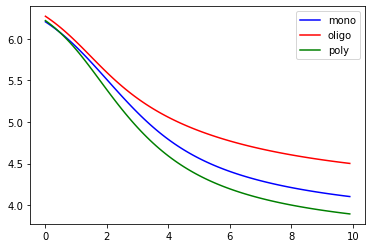

In [3]:
# Test on repertoires
hill_mono = hill_diversity(data_mono, hill = False)
hill_oligo = hill_diversity(data_oligo, hill = False)
hill_poly = hill_diversity(data_poly, hill = False)

# Plot 
plt.figure()
x = np.arange(0, 10, 0.1)
plt.plot(x, hill_mono, 'b-', label='mono')
plt.plot(x, hill_oligo, 'r-', label='oligo')
plt.plot(x, hill_poly, 'g-', label='poly')
plt.legend(loc='upper right')

# Try with exported tsv file from R

## II./ Pairwise Distance Distribution 

Le vecteur Pairwise Distence Distance utilise la distance de Levenshtein. <br>
On commence donc par définir une fonction qui calcule cette distance entre 2 mots.

## Levenshtein distance between two words

In [4]:

def levenshtein(x, y) :
    """
    input1 x : first word, str type
    input2 y : second word, str type
    output1 dist : levenshtein distance between the two words
    """
    
    distances = np.zeros((len(x) + 1, len(y) + 1))

    for t1 in range(len(x) + 1):
        distances[t1][0] = t1

    for t2 in range(len(y) + 1):
        distances[0][t2] = t2
        
    a = 0
    b = 0
    c = 0
    
    for t1 in range(1, len(x) + 1):
        for t2 in range(1, len(y) + 1):
            if (x[t1-1] == y[t2-1]):
                distances[t1][t2] = distances[t1 - 1][t2 - 1]
            else:
                a = distances[t1][t2 - 1]
                b = distances[t1 - 1][t2]
                c = distances[t1 - 1][t2 - 1]
                
                if (a <= b and a <= c):
                    distances[t1][t2] = a + 1
                elif (b <= a and b <= c):
                    distances[t1][t2] = b + 1
                else:
                    distances[t1][t2] = c + 1

    #printDistances(distances, len(x), len(y))
    return distances[len(x)][len(y)]
    
    
def printDistances(distances, x, y):
    for t1 in range(x + 1):
        for t2 in range(y + 1):
            print(int(distances[t1][t2]), end=" ")
        print()   
        
levenshtein('kelm', 'hello')
    

3.0

## Compute Distance Vector

In [6]:
# with levenshtein module for less complexity
import Levenshtein as lv

def PDDistribution(x, column = 'sequence_alignment') :
    """
    input1 x : repertoire as panda dataframe
    input2 column : column on which the sequence are, sequence_alignment as default
    output1 vect : vector that contains levenshtein distance for each pair of words
    """
    
    X = x[column]
    vect = []
    
    for i in range(len(X)) :
        for j in range(i+1, len(X)) :
            #vect.append(levenshtein(X[i], X[j]))
            vect.append(lv.distance(X[i], X[j]))
            
    return vect


## Test on repertoires

In [6]:
# Import TSV files

"""data_mono = pd.read_csv('data/l0036_mono_airr.tsv', sep='\t')
data_oligo = pd.read_csv('data/l0036_oligo_airr.tsv', sep='\t')
data_poly = pd.read_csv('data/l0036_poly_airr.tsv', sep='\t')
"""

In [7]:
vect_mono = PDDistribution(data_mono)
vect_oligo = PDDistribution(data_oligo)
vect_poly = PDDistribution(data_poly)

In [8]:
# count values to plot
def count_values(x) :
    vect = []
    for i in range(np.max(x)) :
        vect.append(np.count_nonzero(x == i))
        
    return vect

mono_count = count_values(np.array(vect_mono))
oligo_count = count_values(np.array(vect_oligo))
poly_count = count_values(np.array(vect_poly))


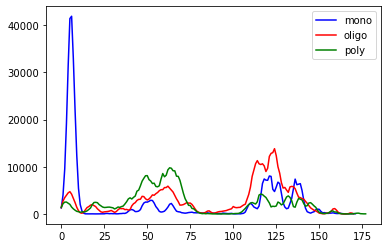

In [9]:
plt.figure(10)
plt.plot(mono_count, 'b-', label='mono')
plt.plot(oligo_count, 'r-', label='oligo')
plt.plot(poly_count, 'g-', label='poly')
plt.legend(loc='upper right')

## III./ Architecture

In [7]:
import networkx as nx

def network(x, col, clone = False, option = 'sequence') :
    """
    Establish a network which nodes represents sequences and edges link sequences 
    with Levenshtein distance = 1
    input1 x : repertoire file as panda dataframe
    input2 col : color of graph, str
    input3 clone : if True we consider all the sequences
                   if False we delete duplicated sequences
    input4 option : column to consider, sequence as default
    output : average degree 
    """
    
    if clone == False :
        #delete duplicate for less complexity
        f = x.drop_duplicates(subset=[option])[option]
    else :
        f = x[option]
    f = np.array(f)
    G = nx.Graph()
    
    for i in range(len(f)) :
        for j in range(i+1, len(f)) :
            G.add_node(i)
            G.add_node(j)
            if lv.distance(f[i], f[j]) <= 1 :
                G.add_edge(i, j, weight = 1)
            
    
    nx.draw(G, with_labels= False, node_color=col)
    plt.show()
    
    # Average Degree
    avg_deg = 0
    for i in range(len(nx.degree(G))) :
        avg_deg += nx.degree(G)[i]
    avg_deg = avg_deg / len(nx.degree(G))
    print('Number of connected components : ', nx.number_connected_components(G))
    print('Average degree : ', avg_deg)
    
    return avg_deg



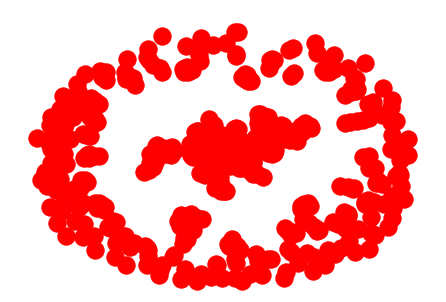

Number of connected components :  148
Average degree :  1.4412955465587045
------------------------------------------


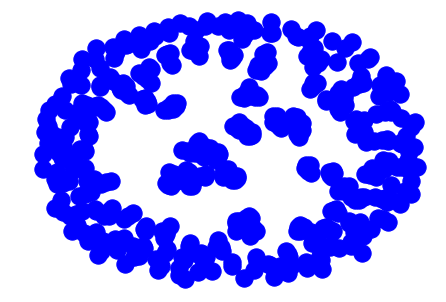

Number of connected components :  202
Average degree :  1.25
------------------------------------------


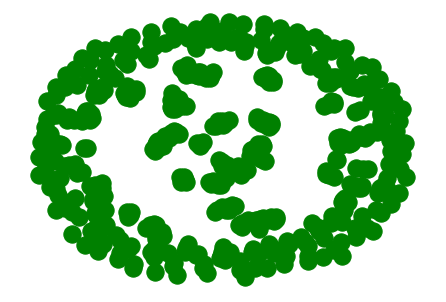

Number of connected components :  203
Average degree :  1.2055888223552895


([<matplotlib.axis.XTick at 0x1e73fcba3d0>,
 [Text(0, 0, 'mono'), Text(1, 0, 'oligo'), Text(2, 0, 'poly')])

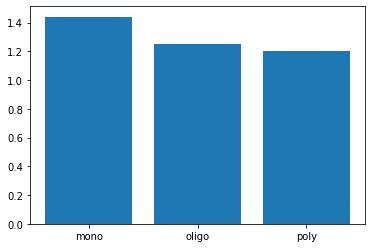

In [8]:
# Test on repertoires
graph_mono = network(data_mono, 'red', clone=False)
print('------------------------------------------')
graph_oligo = network(data_oligo, 'blue', clone=False)
print('------------------------------------------')
graph_poly = network(data_poly, 'green', clone=False)


plt.figure(11)
names = ('mono', 'oligo', 'poly')
h = [graph_mono, graph_oligo, graph_poly]
plt.bar(np.arange(len(h)), h)
plt.xticks(np.arange(len(h)), names)

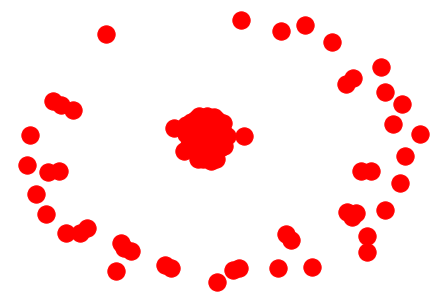

Number of connected components :  35
Average degree :  1.9523809523809523
------------------------------------------


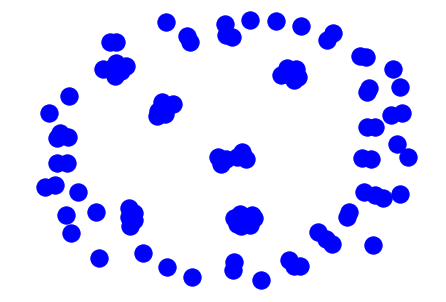

Number of connected components :  45
Average degree :  1.175257731958763
------------------------------------------


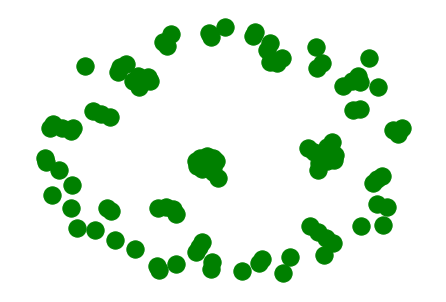

Number of connected components :  46
Average degree :  1.2222222222222223


In [12]:
# with junction_aa column

graph_mono_junction = network(data_mono, col='red', option='junction_aa', clone=False)
print('------------------------------------------')
graph_oligo_junction = network(data_oligo, col='blue', option='junction_aa', clone=False)
print('------------------------------------------')
graph_poly_junction = network(data_poly, col='green', option='junction_aa', clone=False)

([<matplotlib.axis.XTick at 0x1e741a940a0>,
 [Text(0, 0, 'mono'), Text(1, 0, 'oligo'), Text(2, 0, 'poly')])

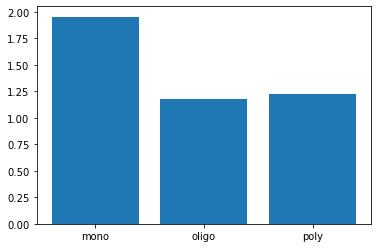

In [13]:
plt.figure(3)
names = ('mono', 'oligo', 'poly')
h = [graph_mono_junction, graph_oligo_junction, graph_poly_junction]
plt.bar(np.arange(len(h)), h)
plt.xticks(np.arange(len(h)), names)